In [34]:
import numpy as np
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
import torch.functional as F 
from torch import nn


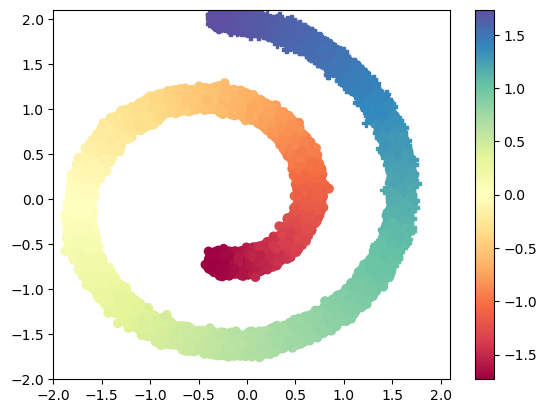

In [35]:
np.random.seed(42)

swiss_roll, t_raw = datasets.make_swiss_roll(100000, noise=0.3)

def normalise(array: np.array):
    shifted = array - np.mean(array)
    scaled = shifted / np.std(array)
    return scaled 

swiss_roll = normalise(swiss_roll)
manifold = normalise(t_raw)

markers = {True: "o",
           False: "P"}

split = manifold < 1
fig, ax = plt.subplots()

norm = colors.Normalize(vmin=manifold.min(), vmax=manifold.max())
cmap = "Spectral"

for side in (True, False):
    msk = split == side
    sc = ax.scatter(normalise(swiss_roll.T[0])[msk], 
                    normalise(swiss_roll.T[2])[msk], 
                    c=manifold[msk], cmap=cmap, norm=norm,
                    marker=markers[side])
    
    ax.set_xlim(-2, 2.1)
    ax.set_ylim(-2, 2.1)

fig.colorbar(sc)

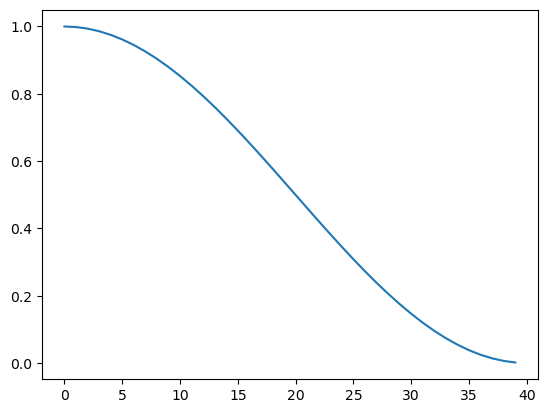

In [36]:
X = torch.tensor(swiss_roll[:, [0, 2]], dtype=torch.float32)

diffusion_steps = 40 
s = 0.0008
t = torch.arange(0, 40, 1)

schedule = torch.cos((t/diffusion_steps + s) / (1 + s) * torch.pi / 2) ** 2
bar_alphas = schedule / schedule[0]
alphas = bar_alphas / torch.concat((bar_alphas[0:1], bar_alphas[0:-1]))
betas = 1 - alphas 

plt.plot(bar_alphas)


In [37]:
noiselevel = 20

def noise(x, t):
    eps = torch.randn_like(x)
    mu = (bar_alphas[t] ** 0.5).repeat(1, x.shape[1]) * x
    var = ((1 - bar_alphas[t]) ** 0.5).repeat(1, x.shape[1]) * eps

    return mu + var, eps

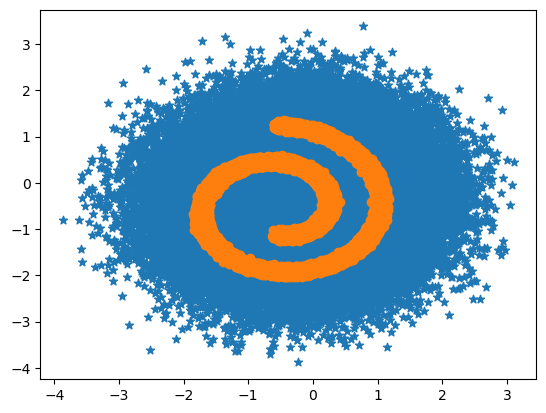

In [38]:
noisy_x, eps = noise(X, 20) 

plt.scatter(noisy_x[:, 0], noisy_x[:, 1], marker = "*")
plt.scatter(X[:, 0], X[:, 1], marker = "o")

In [39]:
noisy_x.shape

torch.Size([100000, 2])

In [40]:
unnoised = 1 / bar_alphas[20] ** 0.5 * (noisy_x - (1 - bar_alphas[20]) ** 0.5 * eps) 

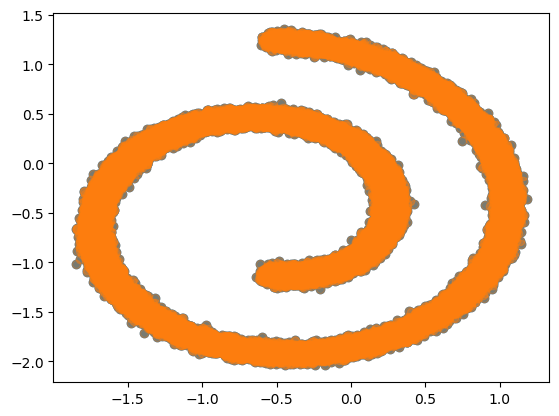

In [41]:
plt.scatter(X[:, 0], X[:, 1], marker = "o")
plt.scatter(unnoised[:, 0], unnoised[:, 1], alpha=0.4)

In [42]:
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x):
        x = self.linear(x)
        return nn.functional.relu(x)

class DiffusionModel(nn.Module):
    def __init__(self, n_features, n_blocks=4, n_units=64): 
        super(DiffusionModel, self).__init__()

        self.inblock = nn.Linear(n_features + 1, n_units)
        self.blocks = nn.ModuleList([
            DiffusionBlock(n_units) for _ in range(n_blocks)
        ])
        self.outblock = nn.Linear(n_units, n_features)

    def forward(self, x, t):
        x = torch.hstack((x, t))
        x = self.inblock(x)
        for block in self.blocks:
            x = block(x)
        return self.outblock(x)


In [43]:
model = DiffusionModel(2, 4, 64) 

device = 'cpu'

model.to(device)

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-3): 4 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

In [44]:
import torch.optim as optim
model = DiffusionModel(2, 4, 64) 

device = 'cpu'

model.to(device)

batch_size = 2048
n_epochs = 100


loss_fn = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LinearLR(optimiser, start_factor=1.0, end_factor=0.01, total_iters=n_epochs)

for epoch in range(n_epochs):
    epoch_loss = steps = 0
    for i in range(0, len(X[split]), batch_size):
        XBatch = X[split][i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(XBatch), 1])
        Xnoise, eps = noise(XBatch, timesteps)
        pred_eps = model(Xnoise.to(device), timesteps.to(device))
        loss = loss_fn(pred_eps, eps.to(device))
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        steps += 1 
        epoch_loss += loss
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")


Epoch 0 loss = 0.7283874750137329
Epoch 1 loss = 0.4722760021686554
Epoch 2 loss = 0.4533226191997528
Epoch 3 loss = 0.44905251264572144
Epoch 4 loss = 0.4420146048069
Epoch 5 loss = 0.4356173872947693
Epoch 6 loss = 0.43107596039772034
Epoch 7 loss = 0.43238115310668945
Epoch 8 loss = 0.4189414083957672
Epoch 9 loss = 0.41469642519950867
Epoch 10 loss = 0.41302138566970825
Epoch 11 loss = 0.4066466689109802
Epoch 12 loss = 0.40608108043670654
Epoch 13 loss = 0.40718206763267517
Epoch 14 loss = 0.39677557349205017
Epoch 15 loss = 0.39720290899276733
Epoch 16 loss = 0.3929319679737091
Epoch 17 loss = 0.39109811186790466
Epoch 18 loss = 0.39469820261001587
Epoch 19 loss = 0.38936322927474976
Epoch 20 loss = 0.3906767666339874
Epoch 21 loss = 0.38362184166908264
Epoch 22 loss = 0.3851446211338043
Epoch 23 loss = 0.38513749837875366
Epoch 24 loss = 0.3888741135597229
Epoch 25 loss = 0.3852488398551941
Epoch 26 loss = 0.3847973644733429
Epoch 27 loss = 0.3848986029624939
Epoch 28 loss = 0.3

In [45]:

def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-bar_alphas[t]) ** 0.5) * predicted_noise)
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
            xt += [x]
        return x, xt

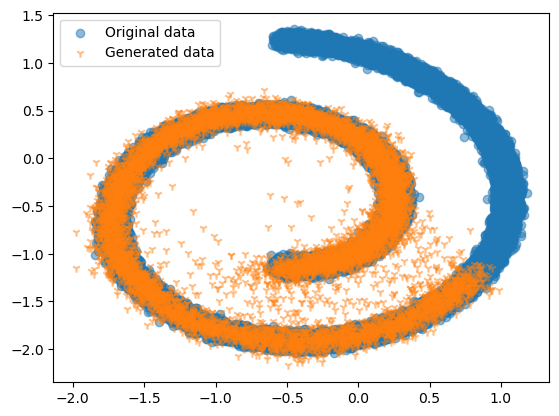

In [46]:
Xgen, Xgen_hist = sample_ddpm(model, 10000, 2)
Xgen = Xgen.cpu()
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(Xgen[:, 0], Xgen[:, 1], marker="1", alpha=0.5)
plt.legend(["Original data", "Generated data"])
plt.show()

In [47]:
def sample_ddpm_x0(model, nsamples, nfeatures):
    """Sampler that uses the equations in DDPM paper to predict x0, then use that to predict x_{t-1}
    
    This is how DDPM is implemented in HuggingFace Diffusers, to allow working with models that predict
    x0 instead of the noise. It is also how we explain it in the Mixture of Diffusers paper.
    """
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # Predict original sample using DDPM Eq. 15
            x0 = (x - (1 - bar_alphas[t]) ** (0.5) * predicted_noise) / bar_alphas[t] ** (0.5)
            # Predict previous sample using DDPM Eq. 7
            c0 = (bar_alphas[t-1] ** (0.5) * betas[t]) / (1 - bar_alphas[t])
            ct = alphas[t] ** (0.5) * (1 - bar_alphas[t-1]) / (1 - bar_alphas[t])
            x = c0 * x0 + ct * x
            # Add noise
            if t > 1:
                # Instead of variance = betas[t] the Stable Diffusion implementation uses this expression
                variance = (1 - bar_alphas[t-1]) / (1 - bar_alphas[t]) * betas[t]
                variance = torch.clamp(variance, min=1e-20)
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
        return x

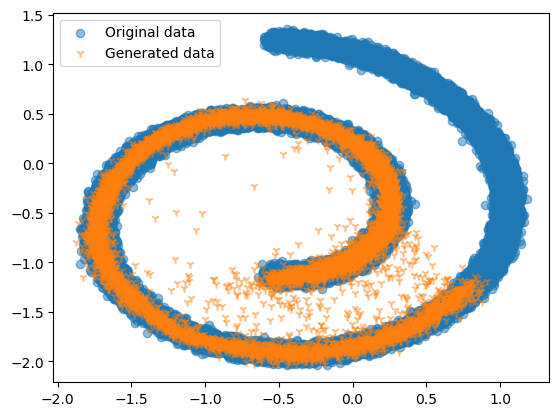

In [48]:
Xgen = sample_ddpm_x0(model, 10000, 2).cpu()
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(Xgen[:, 0], Xgen[:, 1], marker="1", alpha=0.5)
plt.legend(["Original data", "Generated data"])
plt.show()

In [49]:
class GuidanceBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GuidanceBlock, self).__init__()
        self.layer = nn.Linear(input_dim, output_dim)
        self.dropout =  nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.layer(x)
        x = torch.sin(x) 
        x = self.dropout(x)
        return x
    
class GuidanceModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, output_dim=2, n_hidden_layers=2):
        super(GuidanceModel, self).__init__()

        self.inlayer = GuidanceBlock(input_dim, hidden_dim)
        self.midlayer = nn.ModuleList([GuidanceBlock(hidden_dim, hidden_dim) for _ in range(n_hidden_layers)])
        self.outlayer = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        x = self.inlayer(x)
        for layer in self.midlayer: 
            x = layer(x)

        x = self.outlayer(x) 
        mu = x[:, :1]
        var = x[:, 1:]
        return mu, var  
    
class ContextEmbedding(nn.Module):
    def __init__(self, input_dim=2, embedding_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )

    def forward(self, x):
        return self.net(x)



In [50]:
def cgd_regularization_term(
    mean_preds: torch.Tensor, 
    var_preds: torch.Tensor,
    context_embeddings: torch.Tensor,
    covariance_scale_hyper: float,
    diagonal_offset_hyper: float,
    target_variance_hyper: float,
    target_mean_hyper: float, 
):
    """
    Compute the context-guided diffusion regularization term.

    Args:
        model_predictions: Predictions of the guidance model on a noised 
            context batch sampled from a problem-informed context set.
        context_embeddings: The embeddings of the noised context points, derived 
            either from a pre-trained or randomly initialized model.
        covariance_scale_hyper: The covariance scale hyperparameter, used to        
            determine the strength of the smoothness constraints in K(x).
            Optionally scaled with the noising schedule of the forward process.
        diagonal_offset_hyper: The diagonal offset hyperparameter, used to
            determine how closely the predictions have to match m(x).
            Optionally scaled with the noising schedule of the forward process
        target_variance_hyper: The target variance hyperparameter, used to
            determine the level of predictive uncertainty on the context set.

    Returns:
        The context-guided diffusion regularization term.
    """

    from torch.distributions import MultivariateNormal
    from torch.nn.functional import softplus

    # construct the covariance matrix and multiply it with 
    # the covariance scale hyperparameter
    K = torch.matmul(context_embeddings, context_embeddings.T)
    K = K * covariance_scale_hyper

    # add the diagonal offset hyperparameter to the diagonal of K
    K = K + torch.eye(K.shape[0]) * diagonal_offset_hyper

    # specify mean functions that encode the desired behavior of
    # reverting to the context set mean and variance hyperparameter
    mean_target = torch.ones_like(mean_preds) * target_mean_hyper # assuming standardized labels
    var_target = torch.ones_like(var_preds) * target_variance_hyper
    # compute the Mahalanobis distance between the predictions and the
    # mean functions defined above through their log-likelihood under
    # a multivariate Gaussian distribution with covariance K
    means_likelihood = MultivariateNormal(mean_target.T, K)
    vars_likelihood = MultivariateNormal(var_target.T, K)
    mean_log_p = means_likelihood.log_prob(mean_preds.T)
    var_log_p = vars_likelihood.log_prob(var_preds.T)
    log_ps = torch.cat([mean_log_p, var_log_p], dim=0)

    return -log_ps.sum()

In [51]:
def sample_uniform(dims, low, high):
    return (high - low) * torch.rand(size=dims) + (low)

In [138]:
from torch.nn.functional import softplus
def train_guidance_model(
    model, context_encoder, dataloader, optimizer, device,
    l2_lambda=1e-2, sigma_t=1.0, tau_t=1.0,
    target_mean_val=-0.38, target_logvar_val=0.49,  # log(0.7^2)
    ctx_set = None, ctx_size = 32, 
):
    model.train()
    for epoch in range(100):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            mu, r = model(x)

            var = torch.exp(softplus(r))
            # NLL Loss
            dist = torch.distributions.Normal(mu, var ** 1/2)
            nll = -dist.log_prob(y)
            
            
            # CGD Regularization
            if isinstance(ctx_set, torch.Tensor): 
                idx = torch.randperm(ctx_set.size(0))[:ctx_size]
                
                ctx_embeds = context_encoder(ctx_set[idx])

                
                mu_ctx, r_ctx = model(ctx_set[idx])
                logvar_ctx = softplus(r_ctx)
                
                reg = cgd_regularization_term(
                    mu_ctx,
                    logvar_ctx,
                    ctx_embeds,
                    covariance_scale_hyper=sigma_t,
                    diagonal_offset_hyper=tau_t,
                    target_mean_hyper=target_mean_val,
                    target_variance_hyper=target_logvar_val
                )
            
            # 1. Scale reg by dataset size (per epoch)
            reg_scale = len(x)

            # 2. Normalize CGD reg
            reg = reg / reg_scale

            # 3. Rescale based on context size
            reg = reg * (512 / ctx_size)
            
            # L2 Regularization
            l2 = sum((p ** 2).sum() for p in model.parameters())
            loss = nll.mean() + l2_lambda * l2 + reg
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"NLL: {nll.mean().item():.4f}, L2: {l2_lambda * l2:.4f}, Reg: {reg:.4f}")
        print("The mean predicted context", mu_ctx.mean())
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

In [139]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim 

torch.random.manual_seed(42)
class Data(Dataset):
    def __init__(self, x, y):
        super(Dataset, self).__init__()
        self.x = x
        self.y = y
        
        try: 
            assert len(self.x) == len(self.y)
        except:
            raise AssertionError('Len of data and labels must match')

    def __len__(self):
        return len(self.y) 

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

X = torch.tensor(swiss_roll[:, [0, 2]], dtype=torch.float32)
Y = torch.tensor(manifold.reshape(-1, 1), dtype=torch.float32)

data = Data(X[split], Y[split])
dataloader = DataLoader(data, batch_size=128) 

guidance_model = GuidanceModel(2, 32 , 2)
context_encoder = ContextEmbedding(2, 32)
guidance_optimiser = optim.Adam(guidance_model.parameters(), lr=1e-2)

l2_lambda = torch.tensor(1 * 10**-2)
sigma_t = torch.tensor(10**-2)
tau_t = torch.tensor(10**2) 
target_meanval = Y[split].mean().to(device)
target_logvar = torch.tensor([0.7], dtype=torch.float32)

ctx_set = sample_uniform((10000, 2), -2.5, 2.5)
ctx_size = 64

In [140]:
train_guidance_model(guidance_model, context_encoder, dataloader, guidance_optimiser, device, 
                l2_lambda=l2_lambda,
                sigma_t=sigma_t,
                tau_t=tau_t,
                target_mean_val=target_meanval,
                target_logvar_val=target_logvar,
                ctx_set = ctx_set,
                ctx_size=ctx_size)

NLL: 0.3715, L2: 0.2775, Reg: 157.2051
The mean predicted context tensor(-0.2463, grad_fn=<MeanBackward0>)
Epoch 1: Loss = 157.8541
NLL: 0.3657, L2: 0.2721, Reg: 157.1830
The mean predicted context tensor(-0.3160, grad_fn=<MeanBackward0>)
Epoch 2: Loss = 157.8208
NLL: 0.4246, L2: 0.2767, Reg: 157.1971
The mean predicted context tensor(-0.3417, grad_fn=<MeanBackward0>)
Epoch 3: Loss = 157.8983
NLL: 0.4400, L2: 0.2765, Reg: 157.1924
The mean predicted context tensor(-0.3863, grad_fn=<MeanBackward0>)
Epoch 4: Loss = 157.9089
NLL: 0.3975, L2: 0.2820, Reg: 157.1939
The mean predicted context tensor(-0.3543, grad_fn=<MeanBackward0>)
Epoch 5: Loss = 157.8734
NLL: 0.4078, L2: 0.2786, Reg: 157.1832
The mean predicted context tensor(-0.3007, grad_fn=<MeanBackward0>)
Epoch 6: Loss = 157.8695
NLL: 0.4158, L2: 0.2708, Reg: 157.1912
The mean predicted context tensor(-0.2796, grad_fn=<MeanBackward0>)
Epoch 7: Loss = 157.8778
NLL: 0.4222, L2: 0.2798, Reg: 157.2006
The mean predicted context tensor(-0.

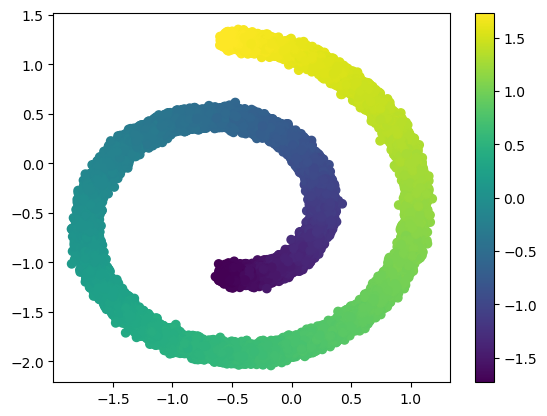

In [141]:
plt.scatter(swiss_roll[:, 0], swiss_roll[:, 2], c=manifold)
plt.colorbar()

In [152]:
from swiss_roll.utils import load_model
path = "/Users/user/Projects/manchester_university/Reproducibility_Project/context-guided-diffusion/swiss_roll/runs/guidance_models/0"
guidance_model = load_model(GuidanceModel, path)

In [153]:
guidance_model.eval()

GuidanceModel(
  (inlayer): GuidanceBlock(
    (layer): Linear(in_features=2, out_features=32, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (midlayer): ModuleList(
    (0-1): 2 x GuidanceBlock(
      (layer): Linear(in_features=32, out_features=32, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (outlayer): Linear(in_features=32, out_features=2, bias=True)
  (softplus): Softplus(beta=1.0, threshold=20.0)
)

/var/folders/8w/vd4m4l915_3c6x0yswt12tfr0000gp/T/ipykernel_3814/3285393699.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  pred_means = np.array(preds[0].detach())


Text(0.5, 1.0, 'Errors on Full Set')

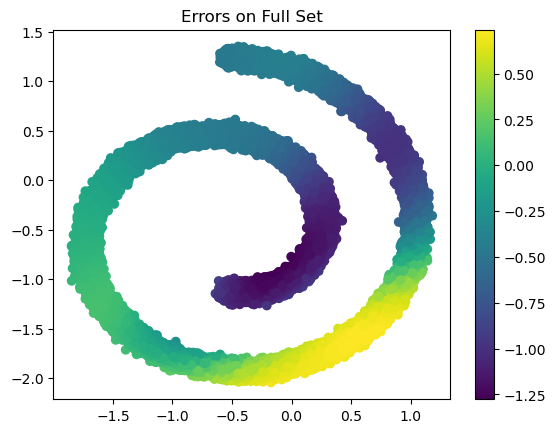

In [154]:
preds = guidance_model(X) 
pred_means = np.array(preds[0].detach())
errors =  pred_means  

ax = plt.scatter(X[:, 0], X[:, 1], c=errors)
plt.colorbar()
plt.title('Errors on Full Set')

/var/folders/8w/vd4m4l915_3c6x0yswt12tfr0000gp/T/ipykernel_3814/68542433.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plt.scatter(X[:, 0], X[:, 1], c=np.array(preds[1].detach()))


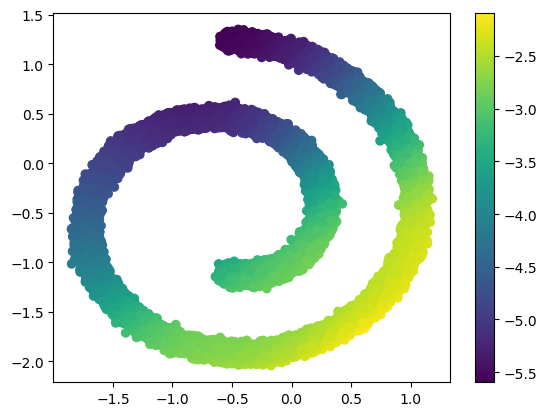

In [155]:
plt.scatter(X[:, 0], X[:, 1], c=np.array(preds[1].detach()))
plt.colorbar()

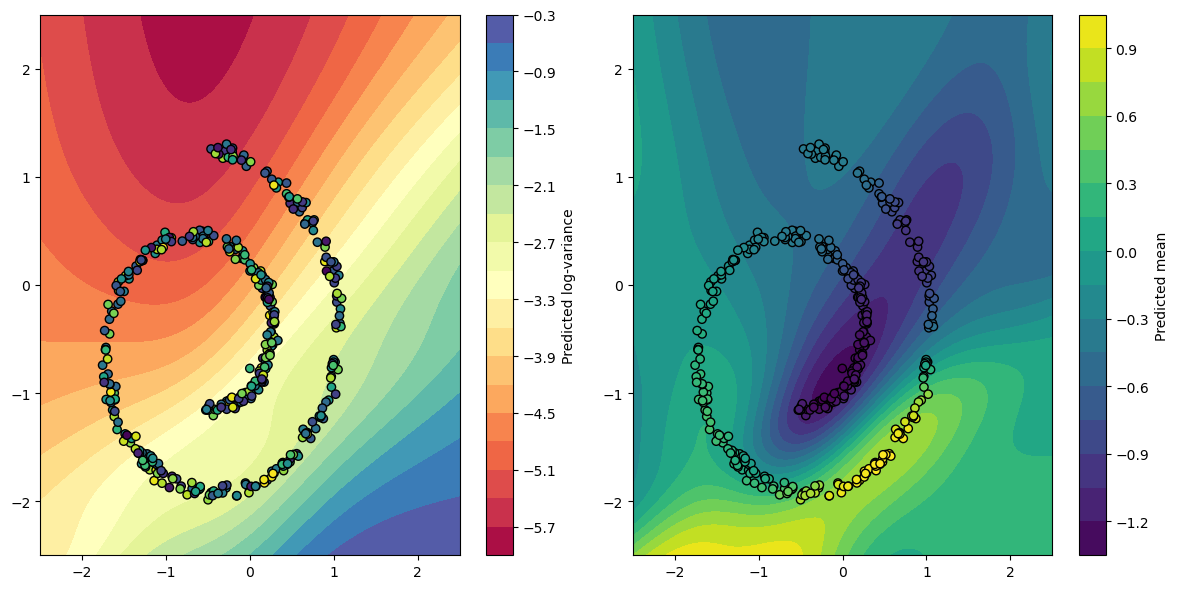

In [156]:
import matplotlib.tri as tri

n = 600
x1_lin = x2_lin = np.linspace(-2.5, 2.5, n)
XX, YY = np.meshgrid(x1_lin, x2_lin)
grid = np.stack([XX.ravel(), YY.ravel()], axis=1)
with torch.no_grad():
    inp = torch.from_numpy(grid).float().to(device)
    mu, logvar = guidance_model(inp)
ZZ = logvar.cpu().numpy().reshape(XX.shape)
ZZ_mu = mu.cpu().numpy().reshape(XX.shape)

fig, ax = plt.subplots(1, 2, figsize=(12,6))
cf = ax[0].contourf(XX, YY, ZZ, levels=20, cmap='Spectral')
cf2 = ax[1].contourf(XX, YY, ZZ_mu, levels=20, cmap='viridis')
fig.colorbar(cf, ax=ax[0], label='Predicted log-variance')
fig.colorbar(cf2, ax=ax[1], label='Predicted mean')

idx = torch.randperm(len(X))[: 400]
ax[0].scatter(X[idx, 0], X[idx, 1], c=logvar[idx], alpha=1, edgecolors='black')
ax[1].scatter(X[idx, 0], X[idx, 1], c=pred_means[idx], alpha=1, edgecolors='black')

plt.tight_layout()

In [78]:
def predicted_mu(eps_pred, x, t):
    mu = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-bar_alphas[t]) ** 0.5) * eps_pred) 
    return mu



In [62]:
def sample_ddpm_alter(model, nsamples, nfeatures, y, guidance_scale):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    x = torch.randn(size=(nsamples, nfeatures)).to(device)
    xt = [x]
    for t in range(diffusion_steps-1, 0, -1):
        with torch.no_grad():
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # See DDPM paper between equations 11 and 12
            variance = betas[t]
            std = variance ** (0.5)
            mu = predicted_mu(predicted_noise, x, t)
        if t > 1:
            x.requires_grad_(True) 
            mu_g, r = guidance_model(x)            
            var_g = torch.exp(softplus(r))
            # NLL Loss
            dist = torch.distributions.Normal(mu_g, var_g ** 0.5)
            nll = dist.log_prob(y * torch.ones_like(mu_g)).sum()
            nll.backward()
            g = x.grad

            # See DDPM paper section 3.2.
            # Choosing the variance through beta_t is optimal for x_0 a normal distribution
            x = mu + std * torch.randn(size=(nsamples, nfeatures)).to(device) + guidance_scale * variance * g
        else: 
            x = mu 
        xt += [x]
    return x, xt

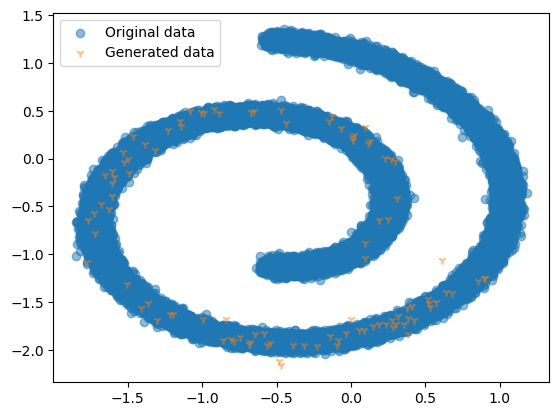

In [63]:
Xgen, Xgen_hist = sample_ddpm_alter(model, 100, 2, 1.35, 1)
Xgen = Xgen.cpu()
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(Xgen[:, 0], Xgen[:, 1], marker="1", alpha=0.5)
plt.legend(["Original data", "Generated data"])
plt.show()